## Семинар 9: "LSTM"

ФИО: Сульженко Родион Вадимович

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from torch import optim
import torch
from torch import nn
import pandas
import sys
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.autograd import Variable
%matplotlib inline

Этот семинар посвящен реализации RNN в pyTorch

## Задание 1

Напишите свою реализацию LSTM.

<img src="https://cdn-images-1.medium.com/max/1600/1*hl9UVtgIcQkDIGD8VFykdw.png" width="640">

In [2]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.gate_size = 4 * self.hidden_size
        
        self.W_i = nn.Parameter(torch.Tensor(input_size, self.gate_size).zero_())
        
        self.W_h = nn.Parameter(torch.Tensor(hidden_size, self.gate_size).zero_())
        
        self.b = nn.Parameter(torch.Tensor(self.gate_size).zero_())
        
        
    def forward(self, inputs, hidden=None):
        # inputs: (seq_len, batch_size, input_size)
        # hidden: (batch_size, hidden_size) x 2. (no layers)
        if hidden is None:
            hidden = [Variable(torch.randn(1,1,self.hidden_size)),
                     Variable(torch.randn(1,1,self.hidden_size))]
        h, c = hidden
        bs = h.size(0)
        
        seq_length = inputs.size(0)
        out = Variable(torch.Tensor(seq_length, bs, self.hidden_size))
        
        for i, inp in enumerate(inputs):
            S = (torch.matmul(inp, self.W_i) + torch.matmul(h, self.W_h) + self.b)
            S = S.view(bs, 4, self.hidden_size)
            
            i_1 = torch.sigmoid(S[:,0,:])
            f_1 = torch.sigmoid(S[:,1,:])
            g_1 = torch.tanh(S[:,2,:])
            o_1 = torch.sigmoid(S[:,3,:])
            
            c = f_1 * c + i_1 * g_1
            h = o_1 * torch.tanh(c)
            out[i] = h
        return out, (h, c)

## Задание 2

Используя свою реализацию LSTM и torch.nn.LSTM (torch.nn.GRU) решить задачу предсказания временного ряда.
Попробуйте разные длины входной и выходной последовательности.
С помощью обученной сети получить из train-части временного ряда test-часть.

Данные о количестве пассажиров
https://datamarket.com/data/set/22u3/international-airline-passengers-monthly-totals-in-thousands-jan-49-dec-60#!ds=22u3&display=line

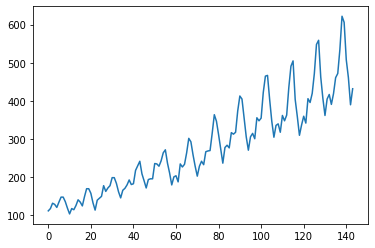

In [3]:
%matplotlib inline
dataset = pandas.read_csv('international-airline-passengers.csv', usecols=[1], delimiter=";", engine='python', skipfooter=3)
plt.plot(dataset)
plt.show()

In [4]:
# подготовливаем данные

dataset = dataset.values
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [5]:
# разбиваем данные на train / test
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))


96 48


In [6]:
# Целевая переменная - сдвинутая последовательность значений входов

def create_dataset(dataset, look_back=1, look_forward=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1-look_forward):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back : (i + look_back + look_forward), 0])

    return np.array(dataX), np.array(dataY)

In [7]:
# Пример подготовленных данных

look_back = 5
look_forward=1
trainX, trainY = create_dataset(train, look_back, look_forward)
testX, testY = create_dataset(test, look_back, look_forward)

trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [8]:
trainX.shape

(89, 1, 5)

In [9]:
train_dataset = TensorDataset(torch.from_numpy(trainX), torch.from_numpy(trainY))
train_dataset

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=5)

In [11]:

def my_train(model, look_back=5, hidden_size=1):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    
    trainX, trainY = create_dataset(train, look_back)
    testX, testY = create_dataset(test, look_back)

    trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
    
    loss_fn = nn.MSELoss()
    
    #train
    epoch_losses = []
    for epoch in range(500):
        losses = []
        for i in range(len(trainY)):
            Y = Variable(torch.FloatTensor(trainY[i:i+1]))
            X = Variable(torch.FloatTensor(trainX[i:i+1]))

            y_pred, _ = model(X)
            current_loss = loss_fn(y_pred, Y)
            losses.append(np.array(current_loss.data))
            
            optimizer.zero_grad()
            current_loss.backward()
            optimizer.step()
        epoch_losses.append(np.mean(losses))
        if epoch % 100 == 0:
            print('\rEpoch {0}... MSE: {1:.10f}, look_back={2}, outp_size={3}'.format(epoch, epoch_losses[-1], look_back, hidden_size))
    predictions = []
    
    #test
    for i in range(len(testY)):
        X = Variable(torch.FloatTensor(testX[i:i+1]))
        Y = Variable(torch.FloatTensor(testY[i:i+1]))
        y_pred, _ = model(X)
        predictions.append(np.array(y_pred.data).mean())
    
    return epoch_losses, predictions, testY

##### MyLSTM:

In [12]:
inp_sizes = [1, 2, 5, 10]
ep_losses_c = []
predictions_c = []
testY_c = []
for look_back in inp_sizes:
    torch_model = LSTM(input_size=look_back, hidden_size=1)
    
    ep_l, pred, t_y = my_train(torch_model, look_back, hidden_size=1)
    ep_losses_c.append(ep_l)
    predictions_c.append(pred)
    testY_c.append(t_y)


Epoch 0... MSE: 0.0503472835, look_back=1, outp_size=1


/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 100... MSE: 0.0020388705, look_back=1, outp_size=1
Epoch 200... MSE: 0.0020592557, look_back=1, outp_size=1
Epoch 300... MSE: 0.0020216871, look_back=1, outp_size=1
Epoch 400... MSE: 0.0020163790, look_back=1, outp_size=1
Epoch 0... MSE: 0.0406272262, look_back=2, outp_size=1
Epoch 100... MSE: 0.0019460578, look_back=2, outp_size=1
Epoch 200... MSE: 0.0018925311, look_back=2, outp_size=1
Epoch 300... MSE: 0.0018892628, look_back=2, outp_size=1
Epoch 400... MSE: 0.0017577707, look_back=2, outp_size=1
Epoch 0... MSE: 0.0386801474, look_back=5, outp_size=1
Epoch 100... MSE: 0.0016514916, look_back=5, outp_size=1
Epoch 200... MSE: 0.0016705072, look_back=5, outp_size=1
Epoch 300... MSE: 0.0015617303, look_back=5, outp_size=1
Epoch 400... MSE: 0.0014507059, look_back=5, outp_size=1
Epoch 0... MSE: 0.0257604606, look_back=10, outp_size=1
Epoch 100... MSE: 0.0013395805, look_back=10, outp_size=1
Epoch 200... MSE: 0.0009700569, look_back=10, outp_size=1
Epoch 300... MSE: 0.0013829885, lo

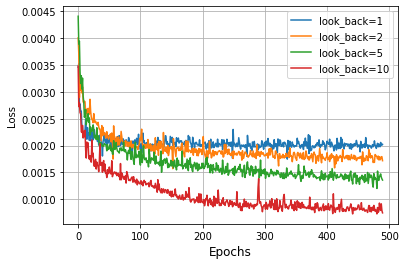

In [13]:
plt.grid('on')
for i, look_back in enumerate(inp_sizes):  
    plt.plot(ep_losses_c[i][10:], label='look_back={}'.format(look_back))
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss')
    plt.legend(loc='best')
plt.show()

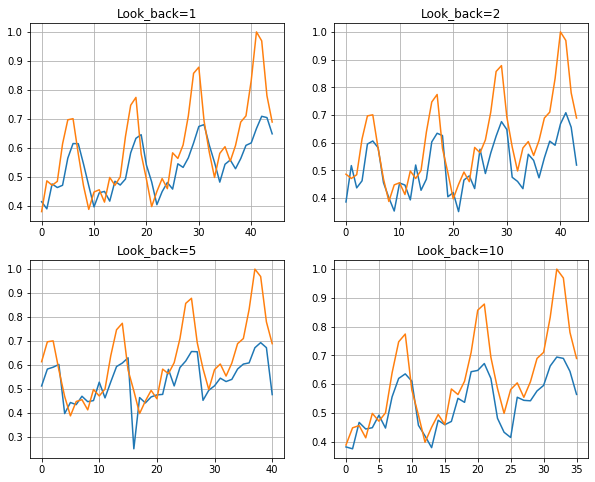

In [14]:
plt.figure(figsize=(10, 8))
for i in range(len(inp_sizes)):
    plt.subplot(2, 2, i + 1)
    plt.grid('on')
    plt.title('Look_back={}'.format(inp_sizes[i]))
    plt.plot(predictions_c[i])
    plt.plot(testY_c[i])



In [15]:
outp_sizes = [1, 2, 5, 10]
ep_losses_c = []
predictions_c = []
testY_c = []
fixed_look_back = 10
for outp_size in outp_sizes:
    torch_model = LSTM(input_size=fixed_look_back, 
                       hidden_size=outp_size)
    ep_l, pred, t_y = my_train(torch_model, look_back=fixed_look_back,
                              hidden_size=outp_size)
    ep_losses_c.append(ep_l)
    predictions_c.append(pred)
    testY_c.append(t_y)


Epoch 0... MSE: 0.0314068459, look_back=10, outp_size=1
Epoch 100... MSE: 0.0014863748, look_back=10, outp_size=1
Epoch 200... MSE: 0.0009648135, look_back=10, outp_size=1
Epoch 300... MSE: 0.0008949043, look_back=10, outp_size=1
Epoch 400... MSE: 0.0008280770, look_back=10, outp_size=1


/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0... MSE: 0.0303295888, look_back=10, outp_size=2
Epoch 100... MSE: 0.0014151494, look_back=10, outp_size=2
Epoch 200... MSE: 0.0013706982, look_back=10, outp_size=2
Epoch 300... MSE: 0.0010466879, look_back=10, outp_size=2
Epoch 400... MSE: 0.0008651804, look_back=10, outp_size=2


/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0... MSE: 0.0303307176, look_back=10, outp_size=5
Epoch 100... MSE: 0.0016403493, look_back=10, outp_size=5
Epoch 200... MSE: 0.0015273866, look_back=10, outp_size=5
Epoch 300... MSE: 0.0012746877, look_back=10, outp_size=5
Epoch 400... MSE: 0.0012376523, look_back=10, outp_size=5


/home/rodion/miniconda3/envs/sphere-py37/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1, 1, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0... MSE: 0.0309570972, look_back=10, outp_size=10
Epoch 100... MSE: 0.0017598828, look_back=10, outp_size=10
Epoch 200... MSE: 0.0018558506, look_back=10, outp_size=10
Epoch 300... MSE: 0.0014878712, look_back=10, outp_size=10
Epoch 400... MSE: 0.0015988948, look_back=10, outp_size=10


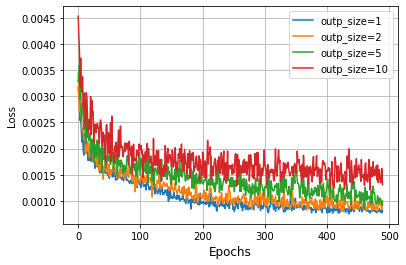

In [16]:
plt.grid('on')
for i, outp_size in enumerate(outp_sizes):  
    plt.plot(ep_losses_c[i][10:], label='outp_size={}'.format(outp_size))
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss')
    plt.legend(loc='best')
plt.show()

##### torch.nn.LSTM

In [17]:
inp_sizes = [1, 2, 5, 10]
ep_losses = []
predictions = []
testY = []
for look_back in inp_sizes:
    torch_model = nn.LSTM(input_size=look_back, hidden_size=1, num_layers=1)
    ep_l, pred, t_y = my_train(torch_model, look_back=look_back, hidden_size=1)
    ep_losses.append(ep_l)
    predictions.append(pred)
    testY.append(t_y)


Epoch 0... MSE: 0.0041526086, look_back=1, outp_size=1
Epoch 100... MSE: 0.0021040100, look_back=1, outp_size=1
Epoch 200... MSE: 0.0020691622, look_back=1, outp_size=1
Epoch 300... MSE: 0.0020503383, look_back=1, outp_size=1
Epoch 400... MSE: 0.0020376258, look_back=1, outp_size=1
Epoch 0... MSE: 0.0053237611, look_back=2, outp_size=1
Epoch 100... MSE: 0.0019374220, look_back=2, outp_size=1
Epoch 200... MSE: 0.0018480743, look_back=2, outp_size=1
Epoch 300... MSE: 0.0018036630, look_back=2, outp_size=1
Epoch 400... MSE: 0.0017798909, look_back=2, outp_size=1
Epoch 0... MSE: 0.0060978369, look_back=5, outp_size=1
Epoch 100... MSE: 0.0019278915, look_back=5, outp_size=1
Epoch 200... MSE: 0.0018121878, look_back=5, outp_size=1
Epoch 300... MSE: 0.0016918372, look_back=5, outp_size=1
Epoch 400... MSE: 0.0015679310, look_back=5, outp_size=1
Epoch 0... MSE: 0.0062474138, look_back=10, outp_size=1
Epoch 100... MSE: 0.0013024020, look_back=10, outp_size=1
Epoch 200... MSE: 0.0012199675, look_

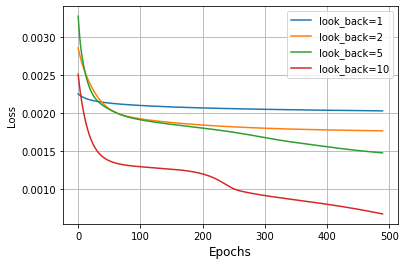

In [18]:
plt.grid('on')
for i, look_back in enumerate(inp_sizes):  
    plt.plot(ep_losses[i][10:], label='look_back={}'.format(look_back))
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss')
    plt.legend(loc='best')
plt.show()

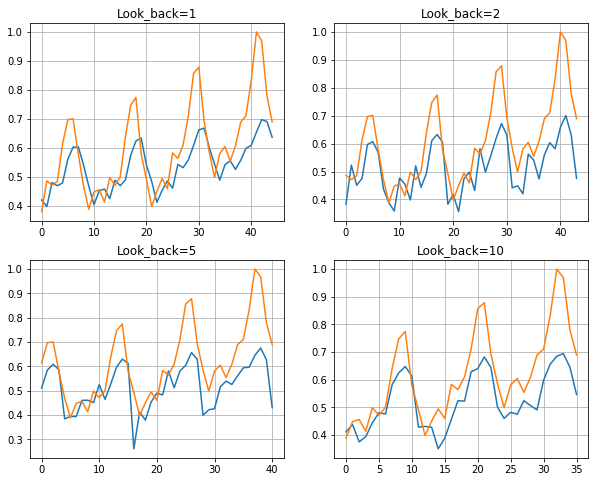

In [19]:
plt.figure(figsize=(10, 8))
for i in range(len(inp_sizes[:4])):
    plt.subplot(2, 2, i + 1)
    plt.grid('on')
    plt.title('Look_back={}'.format(inp_sizes[i]))
    plt.plot(predictions[i])
    plt.plot(testY[i])



In [20]:
outp_sizes = [1, 2, 5, 10]
ep_losses = []
predictions = []
testY = []
fixed_look_back = 10
for outp_size in outp_sizes:
    torch_model = nn.LSTM(input_size=fixed_look_back, 
                          hidden_size=outp_size, num_layers=1)
    ep_l, pred, t_y = my_train(torch_model, look_back=fixed_look_back,
                              hidden_size=outp_size)
    ep_losses.append(ep_l)
    predictions.append(pred)
    testY.append(t_y)


Epoch 0... MSE: 0.0097004669, look_back=10, outp_size=1
Epoch 100... MSE: 0.0013089181, look_back=10, outp_size=1
Epoch 200... MSE: 0.0012398863, look_back=10, outp_size=1
Epoch 300... MSE: 0.0011825352, look_back=10, outp_size=1
Epoch 400... MSE: 0.0008814391, look_back=10, outp_size=1
Epoch 0... MSE: 0.0174286272, look_back=10, outp_size=2
Epoch 100... MSE: 0.0012723078, look_back=10, outp_size=2
Epoch 200... MSE: 0.0010451624, look_back=10, outp_size=2
Epoch 300... MSE: 0.0009545939, look_back=10, outp_size=2
Epoch 400... MSE: 0.0008995347, look_back=10, outp_size=2
Epoch 0... MSE: 0.0072155744, look_back=10, outp_size=5
Epoch 100... MSE: 0.0013462516, look_back=10, outp_size=5
Epoch 200... MSE: 0.0010833611, look_back=10, outp_size=5
Epoch 300... MSE: 0.0009580752, look_back=10, outp_size=5
Epoch 400... MSE: 0.0008905136, look_back=10, outp_size=5
Epoch 0... MSE: 0.0056829504, look_back=10, outp_size=10
Epoch 100... MSE: 0.0013642723, look_back=10, outp_size=10
Epoch 200... MSE: 0.

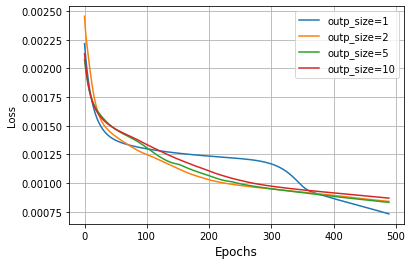

In [21]:
plt.grid('on')
for i, outp_size in enumerate(outp_sizes):  
    plt.plot(ep_losses[i][10:], label='outp_size={}'.format(outp_size))
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss')
    plt.legend(loc='best')
plt.show()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: